In [2]:
import random
import os
import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Run simulation

In [45]:

def make_world(norm, T, alpha, mu, n_nodes=100, k=5, p=0.4, seed=1997):

    """
    Creates a world for the DLU simulation

    Params
        norm: A float in 0 to 1 that describes the chance of talking about domain
        T: Time periods to run simulation for
        alpha = Drift of risk
        mu = Constant of risk
        n_nodes: Number of nodes in WS graph (default 100)
        k: How many neighbors node connected to (default 5)
        p: Rewiring probability (default 0.4)
        seed: Seed for generating graph (default 1997)
    """
    # Generate network
    G = nx.connected_watts_strogatz_graph(n=50, k=10, p=0.06, seed=seed,
                                            tries=100)
    # Generate risk
    risk = generate_data(N=T, mu=mu, alpha=alpha)

    # Initialize nodes
    for node in G:
        look_up = random.choice([0, 0.5, 1])
        bias = random.choice([0.5, 1, 1.5])
        neighbors = list(G.neighbors(node))
        G.nodes[node]['self'] = Agent(node_id=node, graph=G.copy(
        ), norm=norm, look_up=look_up, bias=bias, truth=risk['y'].tolist())

    # Update node beliefs and collect data
    data = []
    for node in G:
        G.nodes[node]['self'].get_expectations(G)
        data.append(G.nodes[node]['self'].expectations['forecasts'])
    a = pd.concat(data)
    return a


# Make worlds with different norms 
worlds = []
for norm in np.arange (0, 1.25, 0.25):
    for iteration in range(100):
        world = make_world(norm=norm, T=100, alpha =0, mu=1)
        world['iteration'] = iteration
        worlds.append(world)
results = pd.concat(worlds)  


Text(0.5, 1.0, 'Error by Social Norm to Share Updates')

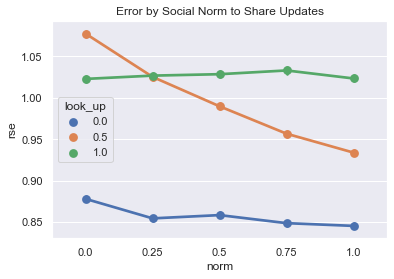

In [46]:
sns.set()
sns.pointplot(x='norm', y='rse', hue='look_up', data=results)
plt.title("Error by Social Norm to Share Updates")

In [9]:
w1 = results.query("norm==1 & iteration==0").head(20)
display(w1)

,belief,truth,t,nid,er,rse,look_up,bias,norm,iteration
0,1.100000,0.577753,0,0,-0.522247,0.522247,0.1,1.1,1.0,0
1,1.100000,1.013912,1,0,-0.086088,0.086088,0.1,1.1,1.0,0
2,1.100000,0.087306,2,0,-1.012694,1.012694,0.1,1.1,1.0,0
3,1.100000,1.624893,3,0,0.524893,0.524893,0.1,1.1,1.0,0
4,1.100000,1.421647,4,0,0.321647,0.321647,0.1,1.1,1.0,0
5,1.100000,1.472785,5,0,0.372785,0.372785,0.1,1.1,1.0,0
6,1.100000,1.102682,6,0,0.002682,0.002682,0.1,1.1,1.0,0
7,1.100000,0.842485,7,0,-0.257515,0.257515,0.1,1.1,1.0,0
8,1.100000,2.454536,8,0,1.354536,1.354536,0.1,1.1,1.0,0
9,1.100000,1.464798,9,0,0.364798,0.364798,0.1,1.1,1.0,0


# Agent defintion

In [24]:
class Agent:
    """
    Agent based model describing belief updating in the prescence of
    different social norms for discussing a subject
    """
    def __init__(self, node_id, graph, norm, look_up, bias, truth):
        self.node_id = node_id
        self.graph = graph
        self.norm = norm
        self.look_up_threshold = look_up
        self.bias = bias
        self.data = truth
        self.beliefs = [bias]*(len(truth))
        self.changes = self.get_changes()
        self.expctations = None

    def look_up(self, t, G):
        """
        Get current beliefs. 

        If last period was a large change by an agent's standards, 
        then the agent will check data in this period for an informed belief and
        update bias accordingly. 

        If last period was not a large change, then the agent relies on talking to friends. The social norm 
        around domain importance will determine whether agents actually discuss the domain, in which case 
        the new belief becomes the average of the beliefs ofneighbors. Or, the agents might not discuss 
        the domain. In that case, the agent continues believing its bias. 

        Params:
            self: Agent 
            t: Time period
            G: Social graph

        Returns:
            None

        Sets:
            self.beliefs[t]
        """
        if random.uniform(0,1) <= self.look_up_threshold:
#         if abs(self.changes[t-1]) >= self.look_up_threshold:
            self.beliefs[t] = self.data[t-1]
        else:
            self.beliefs[t] = self.talk_to_neighbors(t, G)


    def talk_to_neighbors(self, t, G):
        """
        Discuss with neighbors, update beliefs to neighbor 
        averages if topic comes up (with p = norm)
        
        Params:
            self: Agent 
            t: Time period
            G: Social graph
            
        Returns:
            Average of neighbor beliefs in t-1 if random float < norm 
            else agent's own bias 
        """
        if random.uniform(0, 1) < self.norm:
            beliefs = []
            for node in list(G.neighbors(self.node_id)):
                beliefs.append(G.nodes[node]['self'].beliefs[t-1])
            return np.mean(beliefs)
        else:
            return self.beliefs[t-1]

    def get_changes(self):
        """
        Get percent changes in ground truth
        
        Params:
            Self: Agent object
            
        Returns:
            A list of period-on-period percentage changes
        """
        truth_vals = pd.DataFrame(self.data)
        truth_vals['change'] = truth_vals[0].pct_change(periods=1)
        return truth_vals['change'].tolist()

    def get_expectations(self, G):
        for t in range(len(self.data)):
            self.look_up(t, G)
        df = pd.DataFrame([self.beliefs]).T
        df['truth'] = self.data
        df['t'] = df.index
        df['nid'] = self.node_id
        df.columns = ['belief', 'truth', 't', 'nid']
        df['er'] = (df['truth'] - df['belief'])
        df['rse'] = ((df['truth'] - df['belief'])**2)**0.5
        df['look_up'] = self.look_up_threshold
        df['bias'] = self.bias
        df['norm'] = self.norm

        rmse = (np.diff(df.er) ** 2).mean() ** .5
        self.expectations = {"forecasts": df, "rmse": rmse}


# a = Agent(graph=G, node_id=1, norm=0.5, look_up=1, bias=0,truth=risk['y'].tolist())
# a.get_expectations()
# beliefs = a.expectations['forecasts']
# beliefs[['truth', 'belief']].plot()

# Data generation

<AxesSubplot:>

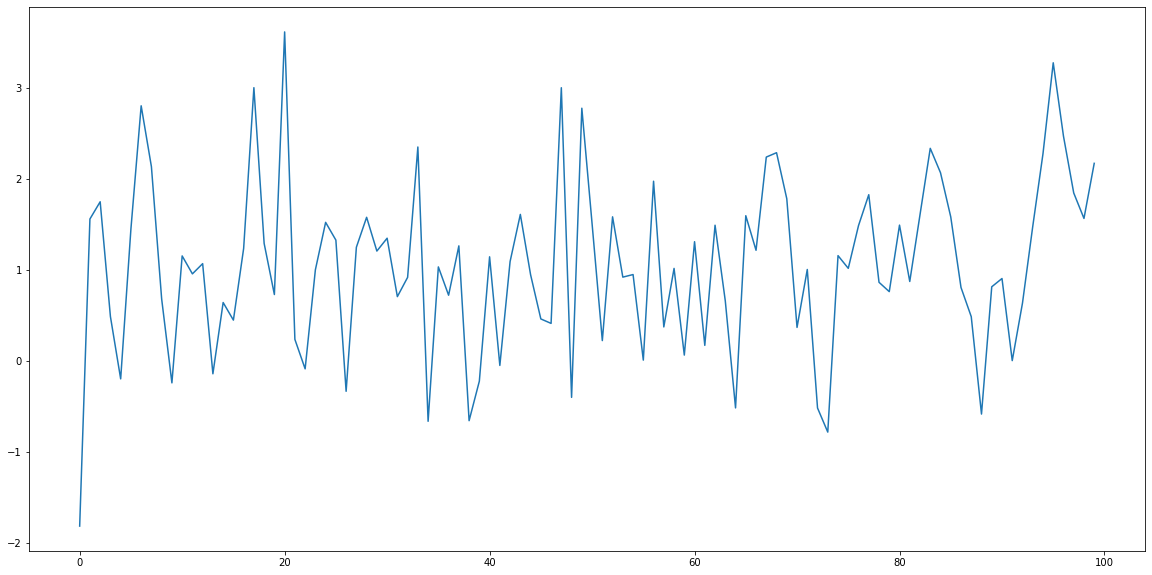

In [4]:
def generate_data(N=100, mu=1, alpha=0.01, lags= [0.2**n for n in range(5)], seed=None):
    """
    Returns simulations from an MA(q) model with drift:
    
    y_t = \mu + \alpha t+ \sum_{j=0}^{q=4} \theta_{j} e_{t-j}
    
    Mu is the mean, alpha is a time trend, and each of the e_t are iid N(0, 1)
    
    Params
        N: Number of periods (default = 100)
        mu: Mean of time series (default = 1)
        alpha: Drift of time series (default = 0.01)
        lags: A list of lag coefficents (default = [0.2**n for n in range(5)])
        seed: Numpy random seed (default = 1997)
        
    Returns:
        A dataframe with column 'y' as value and time as an index 
        
    """
    np.random.seed(seed=None)

    # Array of standard normal noise 
    w = np.random.normal(loc=0, scale=1, size=N)

    # Array of zeros
    y = [0]*(N)

    # Now we build the time series 
    for t in range(0,N):
        # Add mean
        y[t] += mu
        # Add drift 
        y[t] += t*alpha
        # Add weighted average of past errors
        y[t] += sum([lags[lag]*w[t-lag] for lag in range(len(lags)) if t>= lag])
   
    df = pd.DataFrame([y]).T
    df.columns=['y']
    np.random.seed(seed=None)

    return df


risk = generate_data(N=100, alpha=0.001)

risk['y'].plot(figsize=(20, 10))

# Simulation normals

In [3]:
import numpy as np 
import random 

# True value 
theta = 0

# Number of guessers
n = 5

# Generate guesses around true value
np.random.seed(seed=100)
guesses = np.matrix(np.random.uniform(-1, 1, size=n))

# Weights
mat = np.matrix([[1/(n-1) for x in range(1,n+1)]]*5)
mat = np.matrix([[1/(n-1) for x in range(1,n+1)]]*5)

np.fill_diagonal(mat, 0)

# Update beliefs
temp_guess = guesses.copy()
for i in range(10000):
    temp_guess = (np.matmul(mat, temp_guess.T)).T
    
print("Final matrix", temp_guess)
print("Average of initial guesses", np.sum(guesses)/n)

Final matrix [[-0.16168524 -0.16168524 -0.16168524 -0.16168524 -0.16168524]]
Average of initial guesses -0.16168523754209163


In [517]:
np.random.seed(seed=100)
guesses = np.matrix(np.random.uniform(-1, 1, size=n))
guesses = guesses-0


In [520]:
a = np.sum(guesses)/n

In [542]:
print(pd.DataFrame(mat).to_latex(index=False))


\begin{tabular}{rrrrr}
\toprule
   0 &    1 &    2 &    3 &    4 \\
\midrule
0.00 & 0.25 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.00 & 0.25 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.00 & 0.25 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.00 & 0.25 \\
0.25 & 0.25 & 0.25 & 0.25 & 0.00 \\
\bottomrule
\end{tabular}



In [464]:
mat

matrix([[0.  , 0.25, 0.25, 0.25, 0.25],
        [0.25, 0.  , 0.25, 0.25, 0.25],
        [0.25, 0.25, 0.  , 0.25, 0.25],
        [0.25, 0.25, 0.25, 0.  , 0.25],
        [0.25, 0.25, 0.25, 0.25, 0.  ]])

In [18]:
random.choice([0.5, 1, 1.5])

1

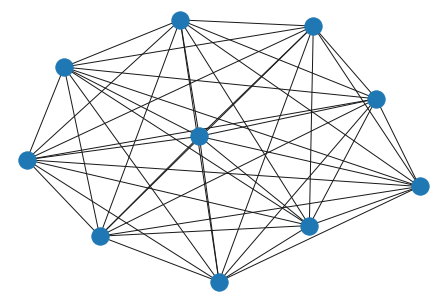

In [42]:
   G = nx.connected_watts_strogatz_graph(n=10, k=10, p=0.08, seed=1997,
                                            tries=100)
    
nx.draw(G)